### Why ResNet?
ResNet was selected because its residual connections help the network learn deeper and more detailed representations without gradient issues. This allows the model to capture subtle waveform patterns more effectively and makes it a strong architecture to compare against EfficientNet-B0 in our evaluation.

In [1]:
%%capture
%run pre_processing2.ipynb

In [2]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [3]:
IMG_SIZE = 224

train_transform = transforms.Compose([ transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                      DenoiseTransform(),
                                       transforms.ColorJitter(brightness=0.15, contrast=0.15),
                                       transforms.RandomAffine(degrees=0, translate=(0.03, 0.03)),
                                       transforms.RandomRotation(3),
                                       transforms.ToTensor(),
                                       transforms.Normalize( mean=[0.485, 0.456, 0.406], std =[0.229, 0.224, 0.225] ), ])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    DenoiseTransform(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    ),
])



In [4]:
class TanafsDataset(Dataset):
    def __init__(self, cropped_df, transform=None):
        self.df = cropped_df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join("newDataset_images", row['image_name'])
        label    = row['label_id']

        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label

In [5]:
BATCH_SIZE = 16

train_dataset = TanafsDataset(train_df, transform=train_transform)
val_dataset   = TanafsDataset(val_df,   transform=val_test_transform)
test_dataset  = TanafsDataset(test_df,  transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

images, labels = next(iter(train_loader))
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)
print("First 5 labels:", labels[:5])


Images shape: torch.Size([16, 3, 224, 224])
Labels shape: torch.Size([16])
First 5 labels: tensor([11,  9,  2,  5,  3])


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


 DataLoaders

Load ResNet18 pretrained

In [8]:
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(cropped_df['label_id'].unique())

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# تعديل آخر طبقة
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)
print("Model loaded on:", device)


Model loaded on: cpu


Loss + Optimizer + Class Weights

In [9]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_df['label_id']),
    y=train_df['label_id']
)

class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Training Loop

In [10]:
EPOCHS = 15

best_val_acc = 0

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total

    # ===== Validation =====
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_resnet18_2.pth")
        print("Saved new BEST model!")

print("Training Complete.")


Epoch 1/15 | Train Loss: 0.8692, Train Acc: 0.7287 | Val Loss: 0.3805, Val Acc: 0.8784
Saved new BEST model!
Epoch 2/15 | Train Loss: 0.3603, Train Acc: 0.8919 | Val Loss: 0.3749, Val Acc: 0.9025
Saved new BEST model!
Epoch 3/15 | Train Loss: 0.2219, Train Acc: 0.9312 | Val Loss: 0.2776, Val Acc: 0.9117
Saved new BEST model!
Epoch 4/15 | Train Loss: 0.1659, Train Acc: 0.9486 | Val Loss: 0.2353, Val Acc: 0.9197
Saved new BEST model!
Epoch 5/15 | Train Loss: 0.1280, Train Acc: 0.9609 | Val Loss: 0.2274, Val Acc: 0.9346
Saved new BEST model!
Epoch 6/15 | Train Loss: 0.1227, Train Acc: 0.9594 | Val Loss: 0.2277, Val Acc: 0.9415
Saved new BEST model!
Epoch 7/15 | Train Loss: 0.0937, Train Acc: 0.9720 | Val Loss: 0.1987, Val Acc: 0.9484
Saved new BEST model!
Epoch 8/15 | Train Loss: 0.0702, Train Acc: 0.9786 | Val Loss: 0.2147, Val Acc: 0.9495
Saved new BEST model!
Epoch 9/15 | Train Loss: 0.0761, Train Acc: 0.9776 | Val Loss: 0.2227, Val Acc: 0.9461
Epoch 10/15 | Train Loss: 0.0673, Train A

The training logs show consistent improvement in both training and validation accuracy. The model continues to generalize well throughout the training process, reaching its best validation performance at epoch 15. The small gap between training and validation accuracy indicates healthy learning with no significant overfitting.


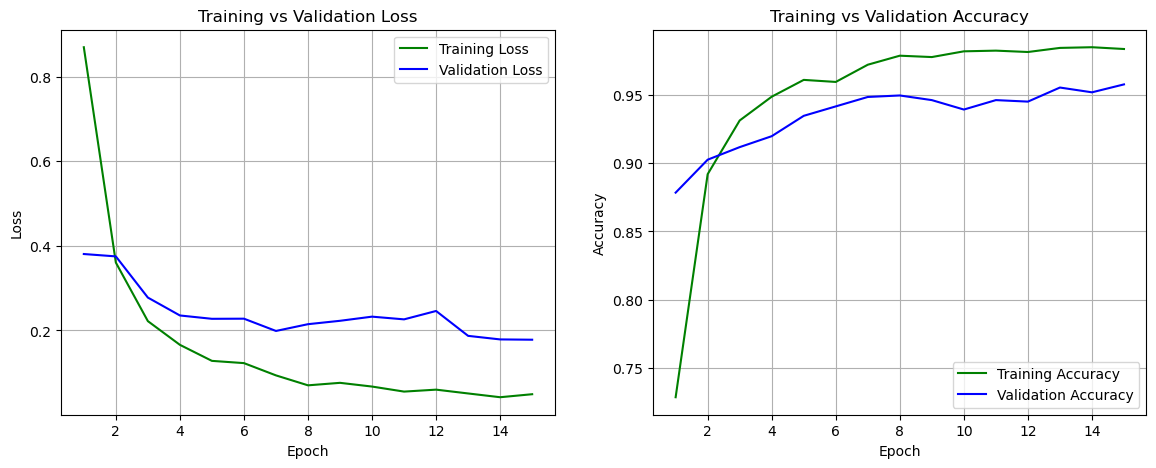

In [11]:
train_losses = [
    0.8692,0.3603,0.2219,0.1659,0.1280,
    0.1227,0.0937,0.0702,0.0761,0.0673,
    0.0554,0.0600,0.0510,0.0421,0.0492
]

val_losses = [
    0.3805,0.3749,0.2776,0.2353,0.2274,
    0.2277,0.1987,0.2147,0.2227,0.2325,
    0.2261,0.2459,0.1871,0.1787,0.1780
]

train_accuracies = [
    0.7287,0.8919,0.9312,0.9486,0.9609,
    0.9594,0.9720,0.9786,0.9776,0.9818,
    0.9823,0.9813,0.9843,0.9848,0.9835
]

val_accuracies = [
    0.8784,0.9025,0.9117,0.9197,0.9346,
    0.9415,0.9484,0.9495,0.9461,0.9392,
    0.9461,0.9450,0.9553,0.9518,0.9576
]



epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 5))

# ===== Loss Plot =====
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='green')
plt.plot(epochs, val_losses, label='Validation Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# ===== Accuracy Plot =====
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='green')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.show()


The figure shows steady improvement in both training and validation curves. Validation accuracy remains close to training accuracy and continues increasing throughout the training process, indicating good generalization


Evaluation on Test Set (Accuracy + F1 + Confusion Matrix)

In [12]:
import torch
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

best_model = model     
state_dict = torch.load("best_resnet18_2.pth", map_location=device)
best_model.load_state_dict(state_dict)
best_model.to(device)


test_loss, test_acc = evaluate(best_model, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Test Loss: 0.2415
Test Accuracy: 0.9393



Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96        85
           1       0.93      0.93      0.93        85
           2       0.97      0.97      0.97        63
           3       0.98      0.97      0.98        63
           4       0.95      0.97      0.96        65
           5       0.88      0.98      0.93        65
           6       0.81      0.99      0.89        68
           7       0.97      0.99      0.98        68
           8       0.99      0.87      0.93        85
           9       0.97      0.91      0.94        85
          10       0.99      0.93      0.96        72
          11       0.89      0.86      0.87        69

    accuracy                           0.94       873
   macro avg       0.94      0.94      0.94       873
weighted avg       0.94      0.94      0.94       873



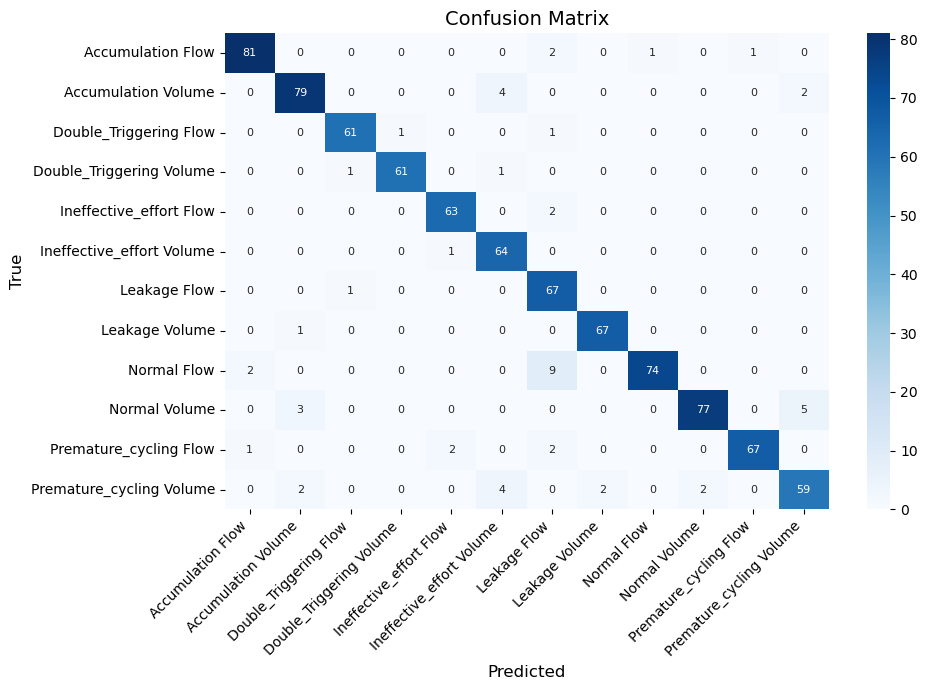

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.load_state_dict(torch.load("best_resnet18_2.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,7))
sns.heatmap(
    cm,
    annot=True,        
    fmt="d",           
    cmap="Blues",     
    xticklabels=CLASSES,
    yticklabels=CLASSES,
    annot_kws={"size": 8}  
)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Classification Report & Confusion Matrix Summary

The classification report shows strong performance, with macro and weighted F1-scores of 0.94, indicating that the model performs very well across all waveform classes. The confusion matrix also displays a clear diagonal pattern, showing that most predictions fall on the correct class, with only a few misclassifications.

**Conclusion:**  
The ResNet model demonstrates strong generalization, achieving a high F1-score of 0.94 on the test set, indicating that its predictions are both reliable and consistent across waveform classes.


## Model Comparison:
EfficientNet-B0 showed stable learning behavior with Training Accuracy ≈ 0.67, Validation Accuracy ≈ 0.73, and a macro F1-score of ~0.72. The model did not show any signs of underfitting or overfitting, but its overall performance remained moderate.

In contrast, ResNet achieved significantly higher performance, reaching Training Accuracy ≈ 0.98, Validation Accuracy ≈ 0.95, and a macro F1-score of 0.94. The validation results remained strong and consistent across epochs, indicating effective learning and good generalization.

**Final Decision:**  
ResNet was selected as the final model because it consistently delivered the highest accuracy, F1-score, and overall detection performance across all classes. It also demonstrated strong generalization and stable validation behavior, making its predictions more reliable and precise. Therefore, ResNet is the preferred choice for deployment.
